In [28]:
import cv2
import numpy as np

image = cv2.imread('./dataset/train/imgs/0/0.jpg', cv2.IMREAD_GRAYSCALE)
image = image.astype('float32')
image

revert_image = np.zeros(image.shape, np.uint8)
for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        revert_image[i][j] = 255 - image[i][j]
revert_image

array([[255, 255, 255, 255, 255, 255, 255, 255, 255, 254, 255, 255, 246,
        255, 255, 255, 240, 255, 255, 252, 255, 251, 252, 255, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 251, 254, 255, 255,
        255, 252, 245, 255, 255, 243, 255, 255, 253, 251, 244, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 252, 253, 255, 255,
        255, 255, 254, 255, 237, 255, 235, 235, 255, 250, 255, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 253, 255, 255, 254, 255,
        245, 255, 255, 255, 246, 255, 255, 255, 248, 252, 250, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 251, 255,
        246, 255, 224, 169, 129, 118,  11,  50, 231, 255, 250, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 249, 255, 249, 255,
        255, 250, 128,   0,   7,   7,   0,   0,  45, 160, 242, 255, 255,
        255, 255],
       [25

In [29]:
import itertools
from paddle.vision import Normalize
import os
import cv2
import numpy as np
from paddle.io import Dataset
from tqdm import tqdm

class MyDataset(Dataset):
    # images = []
    # labels = []
    """
    步骤一：继承 paddle.io.Dataset 类
    """
    def __init__(self, mode='train', transform=None):
        self.images = []
        self.labels = []

        super(MyDataset, self).__init__()
        data_list = []
        with open(f'./dataset/{mode}/label.txt',encoding='utf-8') as f:
            for line in tqdm(f.readlines(), desc='Initializing dataset'):
                image_path, label = line.strip().split('\t')
                image_path = os.path.join(f'./dataset/{mode}', image_path)

                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                # 飞桨训练时内部数据格式默认为float32，将图像数据格式转换为 float32
                # 应用数据处理方法到图像上
                if transform is not None:
                    image = transform(image)
                # CrossEntropyLoss要求label格式为int，将Label格式转换为 int
                label = int(label)
                # 返回图像和对应标签
                revert_image = np.zeros(image.shape, np.uint8)
                for i in range(image.shape[0]):
                    for j in range(image.shape[1]):
                        revert_image[i][j] = 1 - image[i][j]

                image = image.astype('float32')
                self.images.append(image)
                self.labels.append(label)
                revert_image = revert_image.astype('float32')
                self.images.append(revert_image)
                self.labels.append(label)

        self.transform = transform

    def __getitem__(self, index):
        return self.images[index], self.labels[index]

    def __len__(self):
        return len(self.images)

In [30]:
# 定义图像归一化处理方法，这里的CHW指图像格式需为 [C通道数，H图像高度，W图像宽度]
transform = Normalize(mean=[127.5], std=[127.5], data_format='CHW')
# 打印数据集样本数
train_dataset = MyDataset(mode='train', transform=transform)
test_dataset = MyDataset(mode='val', transform=transform)
print('train_custom_dataset images: ',len(train_dataset), 'test_custom_dataset images: ',len(test_dataset))

Initializing dataset: 100%|██████████| 10000/10000 [00:03<00:00, 3183.20it/s]

train_custom_dataset images:  120000 test_custom_dataset images:  20000


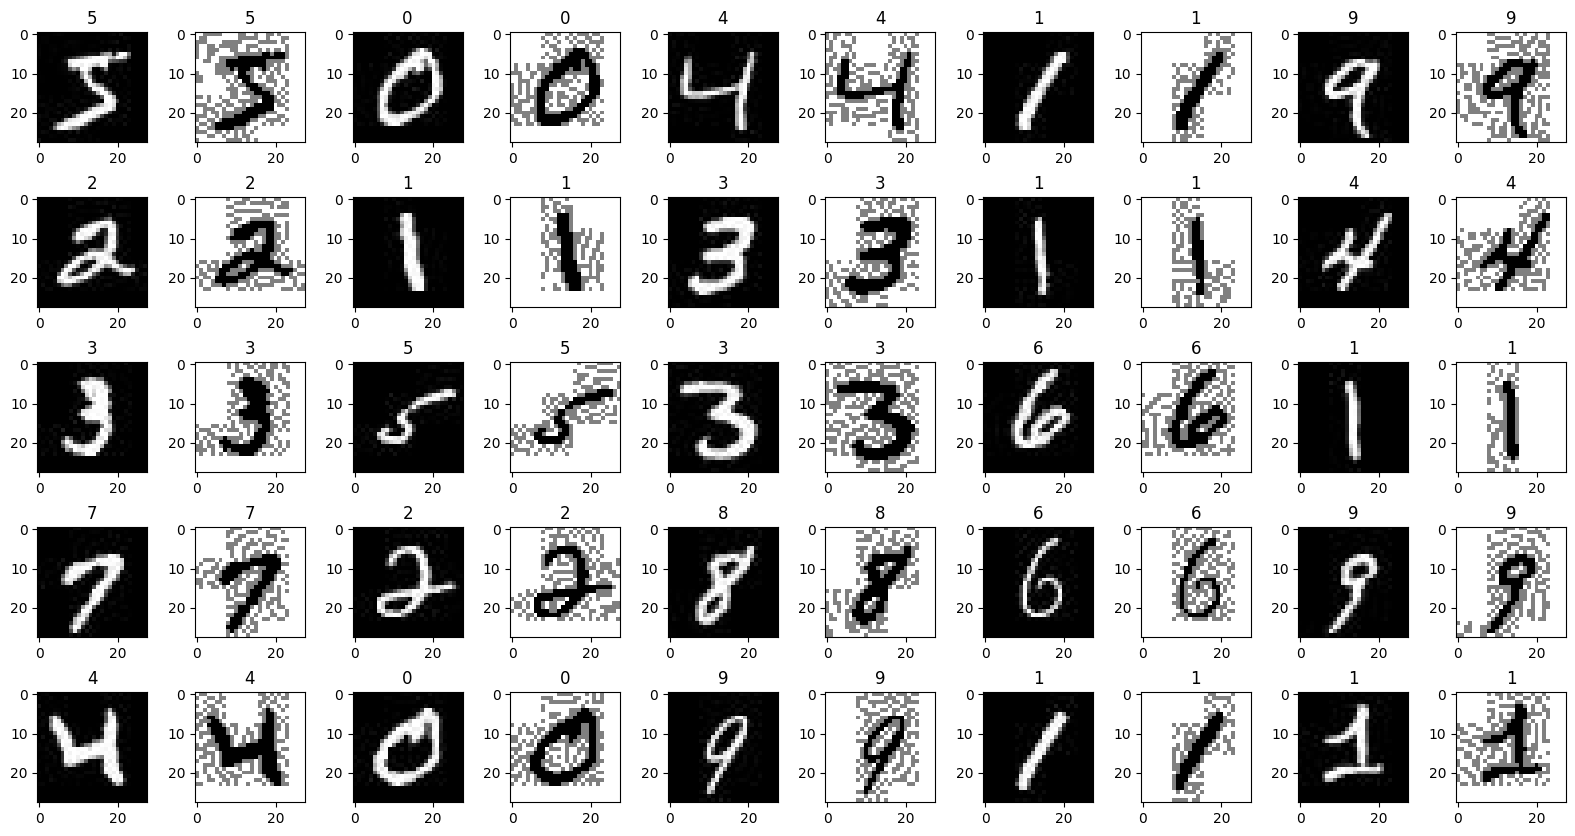

In [32]:
import matplotlib
from matplotlib import pyplot as plt

plt.figure(figsize=(20, 10))
for i, item in enumerate(itertools.islice(train_dataset, 0, 50)):
    # print(img, label)
    plt.subplot(5, 10, i+1)
    image, label = item
    plt.title(str(label))
    plt.imshow(image.squeeze(0), cmap=matplotlib.cm.gist_gray)

plt.subplots_adjust(hspace=0.5)
plt.show()

In [36]:
import os
import random

import numpy as np
# 加载飞桨相关库
import paddle
from paddle.nn import Conv2D, MaxPool2D, Linear
import paddle.nn.functional as F
# 加载visualdl
from visualdl import LogWriter

logwriter = LogWriter(logdir='./runs/mnist_experiment')


train_loader = paddle.io.DataLoader(train_dataset,
                                    batch_size=16,
                                    shuffle=True)

test_loader = paddle.io.DataLoader(test_dataset,
                                   batch_size=16,
                                   shuffle=False)

# 定义mnist数据识别网络模型结构
class MNIST(paddle.nn.Layer):
    def __init__(self):
        super(MNIST, self).__init__()

        # 定义卷积层，输出特征通道out_channels设置为20，卷积核的大小kernel_size为5，卷积步长stride=1，padding=2
        self.conv1 = Conv2D(in_channels=1, out_channels=20, kernel_size=5, stride=1, padding=2)
        # 定义池化层，池化核的大小kernel_size为2，池化步长为2
        self.max_pool1 = MaxPool2D(kernel_size=2, stride=2)
        # 定义卷积层，输出特征通道out_channels设置为20，卷积核的大小kernel_size为5，卷积步长stride=1，padding=2
        self.conv2 = Conv2D(in_channels=20, out_channels=20, kernel_size=5, stride=1, padding=2)
        # 定义池化层，池化核的大小kernel_size为2，池化步长为2
        self.max_pool2 = MaxPool2D(kernel_size=2, stride=2)
        # 定义一层全连接层，输出维度是10
        self.fc = Linear(in_features=980, out_features=10)

    # 定义网络前向计算过程，卷积后紧接着使用池化层，最后使用全连接层计算最终输出
    # 卷积层激活函数使用Relu，全连接层激活函数使用softmax
    def forward(self, inputs):
        x = self.conv1(inputs)
        x = F.relu(x)
        x = self.max_pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.max_pool2(x)
        x = paddle.reshape(x, [x.shape[0], -1])
        x = self.fc(x)
        return x

from models.LeNet import LeNet

#创建模型
model = LeNet()
# model = MNIST()

#保存动态图模型为静态图
paddle.jit.save(model, './runs/mnist_experiment/model', [paddle.static.InputSpec([-1,1,28,28])])

#设置优化器
opt = paddle.optimizer.SGD(learning_rate=0.001, parameters=model.parameters())
EPOCH_NUM = 10

logwriter.add_hparams(hparams_dict={'lr': 0.001, 'batch_size': 16, 'opt': 'sgd'},
                      metrics_list=['train_avg_loss', 'test_avg_loss', 'test_avg_acc'])

for epoch_id in range(EPOCH_NUM):
    model.train()
    train_batchs_per_epoch = len(train_loader)
    for batch_id, data in enumerate(train_loader):
        #准备数据
        images, labels = data

        #前向计算的过程
        predicts = model(images)

        #计算损失，取一个批次样本损失的平均值
        loss = F.cross_entropy(predicts, labels)
        avg_loss = paddle.mean(loss)

        #记录当前训练Loss到VisualDL
        logwriter.add_scalar("train_avg_loss", value=avg_loss.numpy(), step=batch_id+epoch_id*(train_batchs_per_epoch))

        #记录网络中最后一个fc层的参数到VisualDL
        logwriter.add_histogram("fc_weight", values=model.fc.weight.numpy(), step=batch_id+epoch_id*(train_batchs_per_epoch))

        #每训练了100批次的数据，打印下当前Loss的情况
        if batch_id % 200 == 0:
            print("epoch: {}, batch: {}, loss is: {}".format(epoch_id, batch_id, avg_loss.numpy()))

        #后向传播，更新参数的过程
        avg_loss.backward()
        # 最小化loss,更新参数
        opt.step()
        # 清除梯度
        opt.clear_grad()

    # evaluate model after one epoch
    model.eval()
    accuracies = []
    losses = []
    class_probs = []
    class_preds = []
    for batch_id, data in enumerate(test_loader):
        #准备数据
        images, labels = data
        #前向计算的过程
        predicts = model(images)
        #计算损失
        loss = F.cross_entropy(predicts, labels)
        #计算准确率
        acc = paddle.metric.accuracy(predicts, labels)
        accuracies.append(acc.numpy())
        losses.append(loss.numpy())
        #记录用于画pr曲线需要的预测概率和类别
        class_probs_batch = [F.softmax(predict, axis=0) for predict in predicts]
        class_preds_batch = paddle.argmax(predicts, 1)

        class_probs.append(class_probs_batch)
        class_preds.append(class_preds_batch)

    test_probs = paddle.concat([paddle.stack(batch) for batch in class_probs]).numpy()
    test_preds = paddle.concat(class_preds).numpy()

    for i in range(10):
        logwriter.add_pr_curve('class_{}'.format(i), labels=(test_preds == i),predictions=test_probs[:,i], num_thresholds=100, step=epoch_id)

    avg_acc, avg_loss = np.mean(accuracies), np.mean(losses)
    print("[validation]After epoch {}: accuracy/loss: {}/{}".format(epoch_id, avg_acc, avg_loss))
    #记录当前测试集平均Loss和准确率到VisualDL
    logwriter.add_scalar("test_avg_loss", value=avg_loss, step=epoch_id)
    logwriter.add_scalar("test_avg_acc", value=avg_acc, step=epoch_id)

#保存模型参数
paddle.save(model.state_dict(), 'mnist.pdparams')

ValueError: Function: forward doesn't exist in the Module transformed from AST.